# Práctica Spark: Análisis de datos del STC Metro en la CDMX
Para este análisis utilizaremos los datos disponibles en el [Portal de Datos Abiertos de la CDMX](https://datos.cdmx.gob.mx/).

El conjunto de datos que analizaremos es `afluencia-metro.csv` el cual contiene información relevante sobre la cantidad de personas que utilizan este transporte.

## Objetivo del análisis
Responder las siguientes preguntas de acuerdo a los datos utilizados:
- ¿Cuáles son las rutas con mayor congestión?
- ¿En que horarios hay más viajes?
- ¿Qué zonas tienen más entrada o salida de vehículos?

### Instalación de requerimientos

In [ ]:
!pip install findspark matplotlib pandas

### Configuración de Spark

In [9]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Crear la sesión de Spark
spark = SparkSession.builder.appName("PracticaSpark").getOrCreate()

### Lectura del archivo limpio
El código con el que se limpió el conjunto de datos se encuentra en el archivo `limpiar-datos.ipynb`

In [10]:
# Cargar el archivo CSV en un DataFrame
df = spark.read.csv("./work/data/afluencia-metro-corregido.csv", header=True, inferSchema=True)

# Mostrar los primeros registros
df.show()

# Mostrar el esquema del DataFrame
df.printSchema()

# Contar el número de filas
print(f"Número de filas: {df.count()}")


+----------+----+-----+-----+--------------------+---------+
|     fecha|anio|  mes|linea|            estacion|afluencia|
+----------+----+-----+-----+--------------------+---------+
|2010-01-01|2010|Enero|    1|            Zaragoza|    20227|
|2010-01-01|2010|Enero|    1|  Isabel la Católica|     6487|
|2010-01-01|2010|Enero|    1|           Moctezuma|    10304|
|2010-01-01|2010|Enero|    1|         Pino Suárez|     8679|
|2010-01-01|2010|Enero|    1|        Gómez Farías|    19499|
|2010-01-01|2010|Enero|    6|Deportivo 18 de M...|      621|
|2010-01-01|2010|Enero|    6|   La Villa/Basílica|    24792|
|2010-01-01|2010|Enero|    9|           Pantitlán|    27000|
|2010-01-01|2010|Enero|    8|              Aculco|     3652|
|2010-01-01|2010|Enero|    9|           Velódromo|     3239|
|2010-01-01|2010|Enero|    5| Autobuses del Norte|    16824|
|2010-01-01|2010|Enero|    5|           Misterios|     3513|
|2010-01-01|2010|Enero|    7|      Constituyentes|     1417|
|2010-01-01|2010|Enero| 

### ¿Cuáles son las rutas con mayor congestión?
Debido a que los datos no contienen en si una ruta definida, se realizará el análisis para identificar las estaciones y líneas con más afluencia

#### Estaciones con mayor afluencia

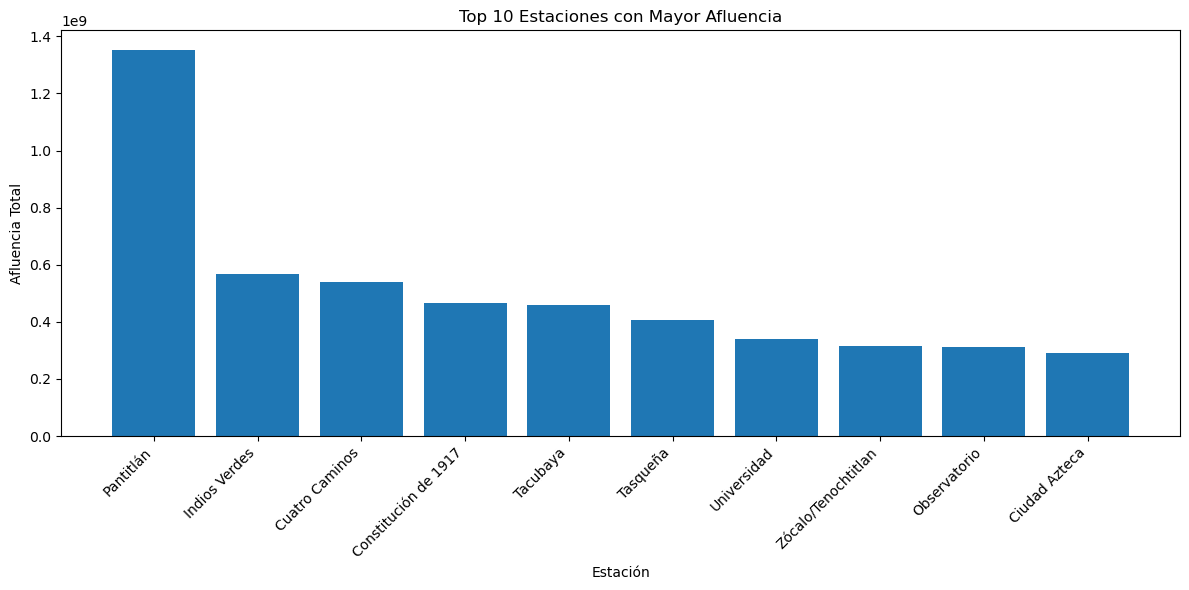

+--------------------+---------------+
|            estacion|afluencia_total|
+--------------------+---------------+
|           Pantitlán|     1353560409|
|       Indios Verdes|      568150097|
|      Cuatro Caminos|      539924090|
|Constitución de 1917|      464611819|
|            Tacubaya|      459622241|
|            Tasqueña|      405889597|
|         Universidad|      341782862|
| Zócalo/Tenochtitlan|      314019228|
|        Observatorio|      312863116|
|       Ciudad Azteca|      289564171|
+--------------------+---------------+



In [11]:
from pyspark.sql.functions import sum, desc
import matplotlib.pyplot as plt
import pandas as pd

# Calcular la afluencia total por estación
afluencia_por_estacion = df.groupBy("estacion").agg(sum("afluencia").alias("afluencia_total"))

# Ordenar por afluencia total y tomar las 10 estaciones con mayor afluencia
top_estaciones = afluencia_por_estacion.orderBy(desc("afluencia_total")).limit(10)

# Convertir a pandas para graficar
top_estaciones_pd = top_estaciones.toPandas()

# Configurar el estilo de la gráfica
plt.figure(1, figsize=(12, 6))
plt.bar(top_estaciones_pd['estacion'], top_estaciones_pd['afluencia_total'])
plt.title('Top 10 Estaciones con Mayor Afluencia')
plt.xlabel('Estación')
plt.ylabel('Afluencia Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Mostrar la tabla de datos
top_estaciones.show()

#### Líneas con más afluencia

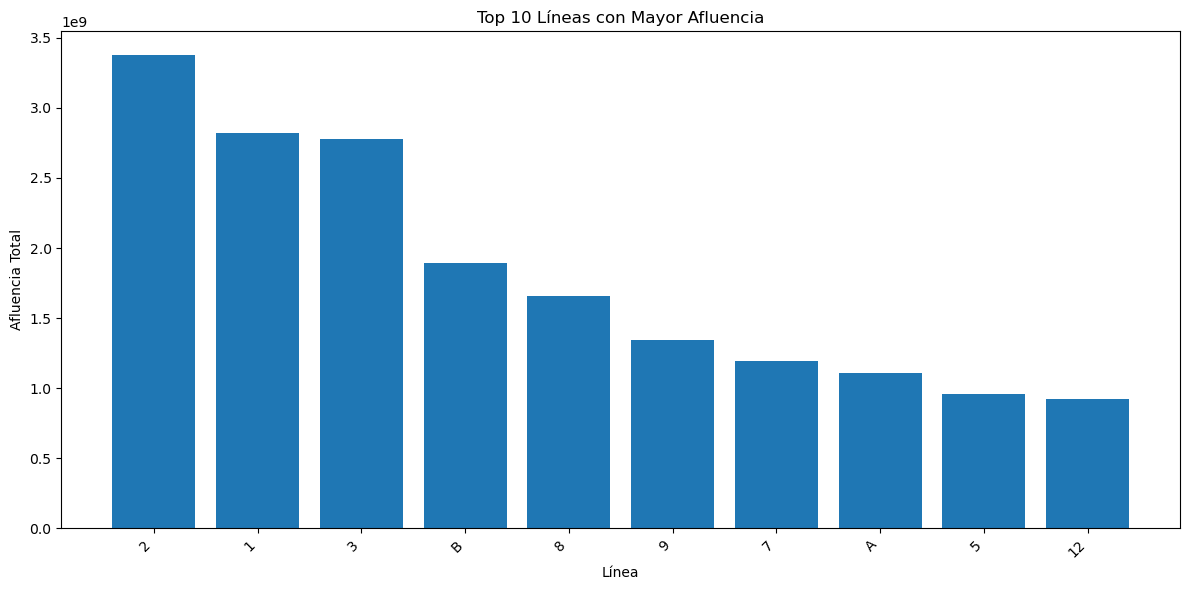

+-----+---------------+
|linea|afluencia_total|
+-----+---------------+
|    2|     3377332442|
|    1|     2819975239|
|    3|     2775837035|
|    B|     1896450326|
|    8|     1659303469|
|    9|     1342267506|
|    7|     1196482827|
|    A|     1110998826|
|    5|      959403666|
|   12|      925984886|
+-----+---------------+



In [12]:
# Calcular la afluencia total por línea
afluencia_por_linea = df.groupBy("linea").agg(sum("afluencia").alias("afluencia_total"))

# Ordenar por afluencia total y tomar las 10 estaciones con mayor afluencia
top_lineas = afluencia_por_linea.orderBy(desc("afluencia_total")).limit(10)

# Convertir a pandas para graficar
top_lineas_pd = top_lineas.toPandas()

# Configurar el estilo de la gráfica
plt.figure(2, figsize=(12, 6))
plt.bar(top_lineas_pd['linea'], top_lineas_pd['afluencia_total'])
plt.title('Top 10 Líneas con Mayor Afluencia')
plt.xlabel('Línea')
plt.ylabel('Afluencia Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Mostrar la tabla de datos
top_lineas.show()

### ¿En qué horario hay más viajes?
El conjunto de datos no contiene esa información, por lo que analizaremos en que meses hay más afluencia y en que años. Para esta operación utilizaremos `reduceByKey`

#### Meses con más afluencia

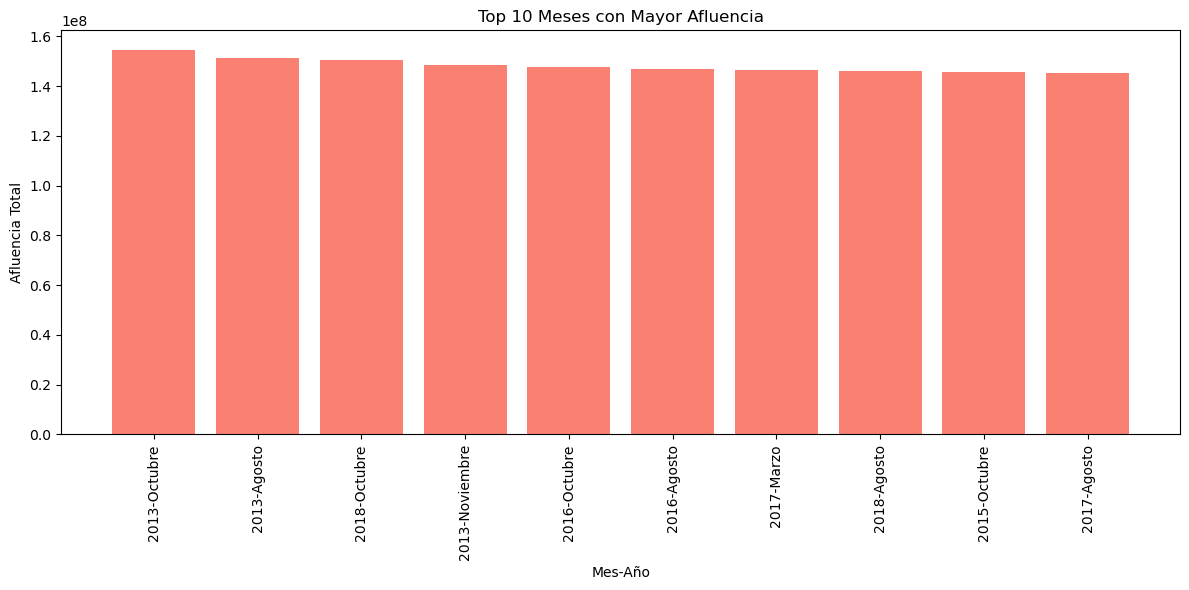

In [15]:
from pyspark import SparkContext

# Convertir el DataFrame en RDD
rdd = df.rdd

# Extraer el año, mes y la afluencia para el análisis
rdd_mes = rdd.map(lambda x: ((x['anio'], x['mes']), x['afluencia']))

# Usar reduceByKey para sumar las afluencias por mes
afluencia_por_mes = rdd_mes.reduceByKey(lambda a, b: a + b).collect()

# Ordenar los resultados por afluencia
afluencia_por_mes.sort(key=lambda x: x[1], reverse=True)

# Obtener solo los 10 meses con mayor afluencia
afluencia_por_mes_top10 = afluencia_por_mes[:10]

# Extraer los meses y las afluencias para graficar
meses = ['{}-{}'.format(m[0][0], m[0][1]) for m in afluencia_por_mes_top10]
afluencias_mes = [m[1] for m in afluencia_por_mes_top10]

# Graficar afluencias por mes
plt.figure(3, figsize=(12, 6))
plt.bar(meses, afluencias_mes, color='salmon')
plt.xlabel('Mes-Año')
plt.ylabel('Afluencia Total')
plt.title('Top 10 Meses con Mayor Afluencia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#### Años con más afluencia

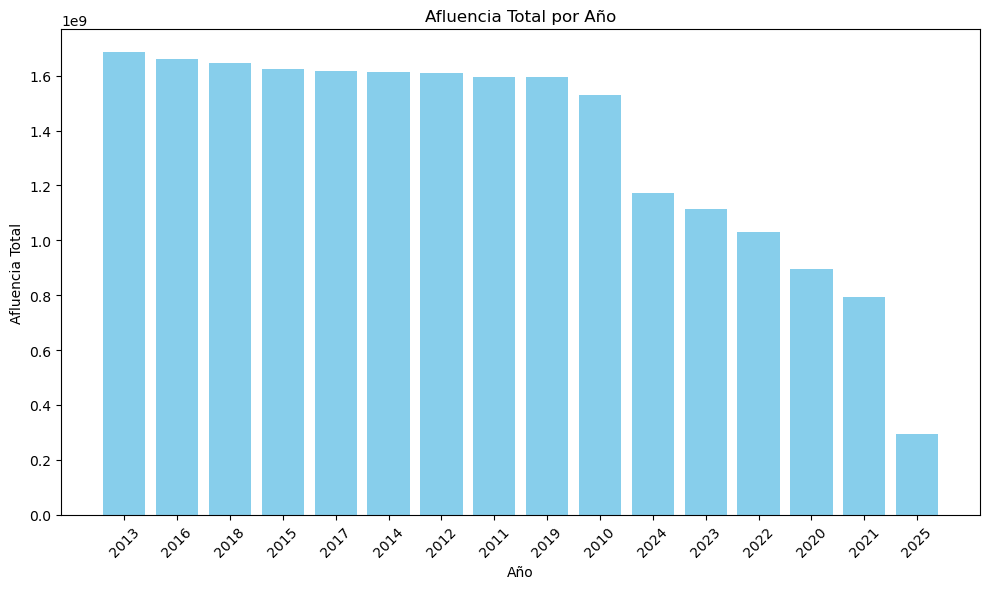

In [16]:
# Extraer el año y la afluencia para el análisis
rdd_anio = rdd.map(lambda x: (x['anio'], x['afluencia']))

# Usar reduceByKey para sumar las afluencias por año
afluencia_por_anio = rdd_anio.reduceByKey(lambda a, b: a + b).collect()

# Ordenar los resultados por afluencia
afluencia_por_anio.sort(key=lambda x: x[1], reverse=True)

# Extraer los años y las afluencias para graficar
años = [str(a[0]) for a in afluencia_por_anio]
afluencias_anio = [a[1] for a in afluencia_por_anio]

# Graficar afluencias por año
plt.figure(4, figsize=(10, 6))
plt.bar(años, afluencias_anio, color='skyblue')
plt.xlabel('Año')
plt.ylabel('Afluencia Total')
plt.title('Afluencia Total por Año')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Guardado y exportado de los resultados
Guardaremos todos los resultados de cada análisis en el directorio `results`

### Exportado de las gráficas
Las gráficas se encontrarán disponibles en `results/graphics`

In [23]:
plt.figure(1)  # Top 10 estaciones
plt.savefig('./work/results/graphics/top10_estaciones.png')

plt.figure(2)  # Top 10 lineas
plt.savefig('./work/results/graphics/top10_lineas.png')

plt.figure(3)  # Afluencia por meses
plt.savefig('./work/results/graphics/afluencia_por_meses.png')

plt.figure(4)  # Afluencia por años
plt.savefig('./work/results/graphics/afluencia_por_anos.png')

## Conclusiones
A partir del análisis realizado sobre los datos de afluencia del Metro de la Ciudad de México, podemos extraer las siguientes conclusiones:

1. Estaciones más concurridas:
    - Se identificaron las 10 estaciones con mayor afluencia, lo que permite conocer los puntos críticos de la red que requieren mayor atención y recursos.
    - Esta información es valiosa para la planificación de mejoras en infraestructura y distribución de personal.

2. Líneas con mayor demanda:
    - El análisis reveló cuáles son las líneas más utilizadas del sistema.
    - Este conocimiento puede guiar decisiones sobre mantenimiento prioritario y posibles expansiones de servicio.

3. Patrones temporales:
    - Se observaron tendencias mensuales en la afluencia de usuarios, identificando períodos de mayor y menor demanda.
    - El análisis por años muestra la evolución histórica del uso del sistema, permitiendo proyectar tendencias futuras.

4. Implicaciones para la gestión:
    - Los resultados proporcionan una base sólida para la toma de decisiones en:
        - Optimización de recursos
        - Planificación de mantenimiento
        - Mejoras en la capacidad del servicio
        - Desarrollo de estrategias para gestionar la demanda

Este análisis contribuye significativamente a la comprensión del comportamiento de los usuarios del Metro y puede ser utilizado como herramienta para mejorar la calidad del servicio.
